#### Importowanie bibliotek

In [1]:
import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator

from warnings import filterwarnings
filterwarnings("ignore")

#### Import zbioru danych z zadania 2

In [4]:
egfr = pd.read_csv("../2_adme_lead-likeness/EGFR_lipinski.csv")
egfr.head()

,passed,Molecular mass,LogP,H-Donors,H-Acceptors,molecule_name,canonical_smiles,pIC50
0,True,383.814,4.45034,3,4,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,7.387216
1,True,369.432,4.77200,1,6,CHEMBL137635,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,5.031517
2,True,283.287,2.31056,2,4,CHEMBL306988,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,3.301030
3,True,370.456,5.58790,1,5,CHEMBL47940,Nc1ncnc2c1c(-c1ccc(Oc3ccccc3)cc1)cn2C1CCCC1,5.494850
4,True,442.515,5.07900,3,3,CHEMBL432941,COc1cccc(-c2ccc3c(c2)NC(=O)/C3=C\c2[nH]c3c(c2C...,5.051587


#### Filtrowanie zbioru danych

In [7]:
egfr_filter = egfr[["molecule_name", "canonical_smiles", "pIC50"]]
egfr_filter.head()

,molecule_name,canonical_smiles,pIC50
0,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,7.387216
1,CHEMBL137635,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,5.031517
2,CHEMBL306988,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,3.301030
3,CHEMBL47940,Nc1ncnc2c1c(-c1ccc(Oc3ccccc3)cc1)cn2C1CCCC1,5.494850
4,CHEMBL432941,COc1cccc(-c2ccc3c(c2)NC(=O)/C3=C\c2[nH]c3c(c2C...,5.051587


#### Zaklasyfikowanie związków >= 6.3 jako aktywnych

In [9]:
egfr_filter['active'] = np.zeros(len(egfr_filter))
egfr_filter.loc[egfr_filter[egfr_filter['pIC50'] >= 6.3].index, 'active'] = 1

print("Number of active compounds:", int(egfr_filter["active"].sum()))
print("Number of inactive compounds:", len(egfr_filter) - int(egfr_filter["active"].sum()))

Number of active compounds: 369
Number of inactive compounds: 298


#### Obliczenie odciskow palcow MACCS

In [10]:
def smiles_to_maccs(smiles):

    mol = Chem.MolFromSmiles(smiles)

    return np.array(MACCSkeys.GenMACCSKeys(mol))

In [12]:
egfr_filter["MACCS"] = egfr_filter['canonical_smiles'].apply(smiles_to_maccs)
egfr_filter.head()

,molecule_name,canonical_smiles,pIC50,active,MACCS
0,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,7.387216,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL137635,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,5.031517,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL306988,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,3.301030,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL47940,Nc1ncnc2c1c(-c1ccc(Oc3ccccc3)cc1)cn2C1CCCC1,5.494850,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL432941,COc1cccc(-c2ccc3c(c2)NC(=O)/C3=C\c2[nH]c3c(c2C...,5.051587,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


#### Zbudowanie modeli klasyfikacyjncyh

#### Podział danych na treningowy i testowy w propocji 80:20

In [22]:
training_x, test_x, training_y, test_y = train_test_split(egfr_filter['MACCS'].to_list(), egfr_filter['active'].to_list(), test_size=0.2, random_state=42)

splits = [training_x, test_x, training_y, test_y]

print("Training data size:", len(training_x))
print("Test data size:", len(test_x))

Training data size: 533
Test data size: 134


#### Zdefiniowanie funkcji pomocnych w procesie oceny modeli

In [16]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig("./roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

In [17]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [18]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

#### RF

In [15]:
rf_params = {
    "n_estimators": 100,
    "criterion": "entropy"
}
model_rf = RandomForestClassifier(**rf_params)

In [23]:
rf_performance_measures = model_training_and_validation(model_rf, "RF", splits)

Sensitivity: 0.85
Specificity: 0.53
AUC: 0.77


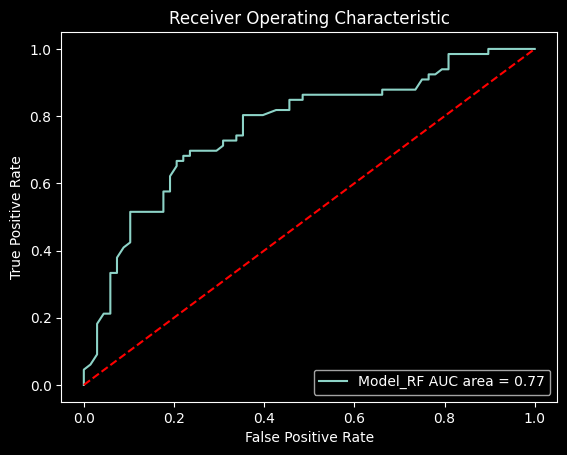

In [24]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_rf}]
# Plot roc curve
plot_roc_curves_for_models(models, test_x, test_y);

#### SVC

In [25]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.89
Specificity: 0.54
AUC: 0.80


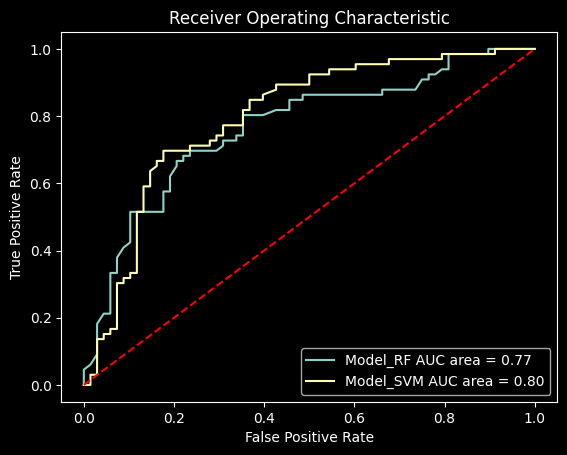

In [26]:
# Append SVM model
models.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(models, test_x, test_y);

#### ACC

In [27]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=42)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.88
Specificity: 0.54
AUC: 0.79


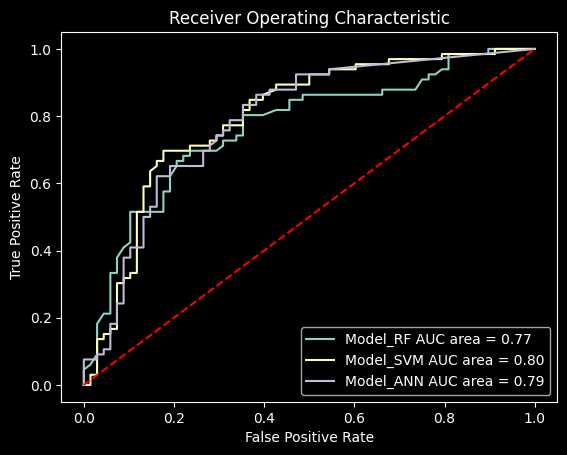

In [28]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(models, test_x, test_y, True);

#### Walidacja krzyżowa

In [29]:
import time

In [32]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index]['MACCS'].tolist()
        train_y = df.iloc[train_index]['active'].tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index]["MACCS"].tolist()
        test_y = df.iloc[test_index]["active"].tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

In [33]:
n_folds = 5

for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], egfr_filter, n_folds=n_folds)


Model_RF
Mean accuracy: 0.67 	and std : 0.03 
Mean sensitivity: 0.75 	and std : 0.05 
Mean specificity: 0.56 	and std : 0.02 
Mean AUC: 0.73 	and std : 0.03 
Time taken : 1.14s


Model_SVM
Mean accuracy: 0.67 	and std : 0.03 
Mean sensitivity: 0.78 	and std : 0.08 
Mean specificity: 0.54 	and std : 0.02 
Mean AUC: 0.74 	and std : 0.03 
Time taken : 0.70s


Model_ANN
Mean accuracy: 0.67 	and std : 0.04 
Mean sensitivity: 0.80 	and std : 0.08 
Mean specificity: 0.53 	and std : 0.06 
Mean AUC: 0.70 	and std : 0.05 
Time taken : 1.09s



#### Interpretacja

Wszystkie modele poradziły sobie relatywnie dobrze. Porównując AUC najlepiej poradził sobie SVM, potem RF i na końcu ANN. Taki wynik mógłby wskazywać na to, że dane wykazują wzorzec, który SVM i RF mogły znaleźć i na jego podstawie tworzyć predykcje. ANN poradził sobie nieznacznie gorzej. Może być tak ze względu na to, że danych jest bardzo mało jak do nauczenia sieci neuronowej.